100%|██████████| 9.91M/9.91M [00:00<00:00, 136MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 40.0MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 106MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.15MB/s]


Epoch 1, D Loss: 0.9670, G Loss: 0.8255
Epoch 2, D Loss: 0.6407, G Loss: 1.4094
Epoch 3, D Loss: 0.8188, G Loss: 1.1649
Epoch 4, D Loss: 0.9068, G Loss: 1.3013
Epoch 5, D Loss: 0.7095, G Loss: 1.6329


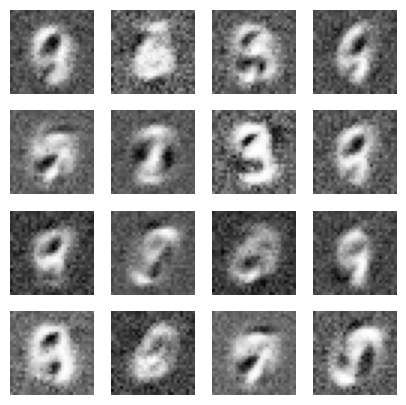

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256), nn.ReLU(),
            nn.Linear(256, 784), nn.Tanh()
        )
    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 256), nn.ReLU(),
            nn.Linear(256, 1), nn.Sigmoid()
        )
    def forward(self, img):
        return self.model(img.view(-1, 784))

dataloader = DataLoader(datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor()), batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen, disc = Generator().to(device), Discriminator().to(device)
opt_G, opt_D = torch.optim.Adam(gen.parameters(), lr=0.0002), torch.optim.Adam(disc.parameters(), lr=0.0002)
criterion = nn.BCELoss()

for epoch in range(5):
    for real, _ in dataloader:
        real = real.to(device)
        batch_size = real.size(0)
        z = torch.randn(batch_size, 100).to(device)
        fake = gen(z)

        disc_loss = criterion(disc(real), torch.ones(batch_size, 1, device=device)) + criterion(disc(fake.detach()), torch.zeros(batch_size, 1, device=device))
        opt_D.zero_grad()
        disc_loss.backward()
        opt_D.step()

        gen_loss = criterion(disc(fake), torch.ones(batch_size, 1, device=device))
        opt_G.zero_grad()
        gen_loss.backward()
        opt_G.step()

    print(f"Epoch {epoch+1}, D Loss: {disc_loss.item():.4f}, G Loss: {gen_loss.item():.4f}")

with torch.no_grad():
    fake_images = gen(torch.randn(16, 100, device=device)).cpu()
plt.figure(figsize=(5,5))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(fake_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
